### Background

A key product metric looks at Daily Active Users over Monthly Active Users (DAU/MAU). It is commonly used as a proxy for user engagement and is widely used by product teams and businesses. I’ve seen a few definitions but the one I use means that DAU, MAU, etc are defined as the count of unique visitors that have visited in the past X days – ie for MAU it is a rolling 30 days.

I recently found I needed to calculate this from a stream of aggregated event data. You could take a similar approach with a pure event stream, but it may be worth grouping by visitors and dates depending on the size of your data so it doesn’t take forever.

Despite searching, I couldn’t find anything that quickly solved my problem so took the following approach:

1. Import pandas and the event stream as a DataFrame (df1);
2. Set up a new DataFrame (df2) with one row for each date in the date range; and
3. Loop through df1 for each date in df2 and record a distinct count of visitors for the relevant period in df2.

The data we'll use can just be generated as follows:

In [77]:
from datetime import datetime as dt, timedelta as td
import numpy as np
import pandas as pd

col_names = ['visitor_id', 'date', 'page_views', 'feature_clicks']

visitor_ids = range(1,51)
dates = [dt(2020, 7, 1) + td(days=x) for x in range(30)]

data = []

for d in dates:
    for id in visitor_ids:
        data.append([id, d, np.random.randint(1e2), np.random.randint(1e3)])

### Code
Step 1 is housekeeping. While we'll use the generated data it would more likely connecting to an API or a database.

In [86]:
full_df = pd.DataFrame(data, columns=col_names)
full_df.sample(5)

,visitor_id,date,page_views,feature_clicks
1255,6,2020-07-26,52,562
1423,24,2020-07-29,21,659
1335,36,2020-07-27,99,919
273,24,2020-07-06,23,609
815,16,2020-07-17,24,854


We'll use an exponential decay function to emulate the drop-off in user activity. This takes the form of $y = ab^x$. We'll keep it simple and use $y = 1.001^{-x}$ as a mask against the index of our new dataframe.

In [119]:
mask = [(1.0005**-i)>np.random.rand() for i in full_df.index]
event_df = full_df.loc[mask]
event_df # roughly a third of the rows have been dropped

,visitor_id,date,page_views,feature_clicks
0,1,2020-07-01,49,814
1,2,2020-07-01,83,857
2,3,2020-07-01,42,215
3,4,2020-07-01,21,309
4,5,2020-07-01,87,312
...,...,...,...,...
1493,44,2020-07-30,46,82
1496,47,2020-07-30,96,729
1497,48,2020-07-30,99,858
1498,49,2020-07-30,22,496


Step 2 has us write our function that will create an active user table with a single row for each date. Pandas has a function we can easily use to do this – date_range.

In [120]:
def setup_active_user_df(df):
    active_user_df = pd.DataFrame({"date": pd.date_range(df['date'].min(), df['date'].max())})
    return active_user_df

Step 3 performs the most work, looping through event_df for each date in our active_users_df. We make sure to use df.loc rather than chained indexing here (e.g. df[col_name][i] ) to avoid potential issues.

In [121]:
def active_users_in_period(active_user_df, event_df, col_name, period):
    active_user_df[col_name] = 0   # Creates the empty column to be filled in
    for i in range(len(active_user_df)):
        origin_date = active_user_df['date'][i]
        offset_date = origin_date - pd.offsets.Day(int(period))
        # filter the original dataframe and count unique visitors
        count = len(event_df.loc[
                                (event_df['date'] <= origin_date) & 
                                (event_df['date'] > offset_date),
                                'visitor_id'].unique())
        active_user_df.loc[i, col_name] = count
    return df

In [122]:
df = setup_active_user_df(event_df)
df = active_users_in_period(df, event_df, 'DAU', 1)
df = active_users_in_period(df, event_df, 'MAU', 30)

# You can also add any period you like e.g. Weekly Active Users (WAU)
df = active_users_in_period(df, event_df, 'WAU', 7)

# Calculate DAU/MAU to be able to use it in the chart
df['DAU/MAU'] = df['DAU']/df['MAU']

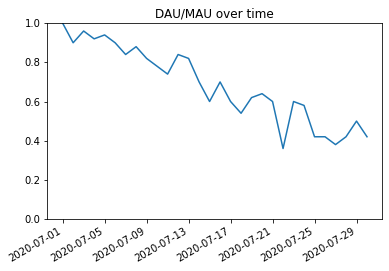

In [123]:
import matplotlib.pyplot as plt

# Set up the chart with minimal formatting
fig, ax = plt.subplots()
ax.plot(df['date'], df['DAU/MAU'])
ax.set_title('DAU/MAU over time')
fig.autofmt_xdate()
ax.set_ylim(0,1)
plt.show()

You could clean this up further by removing the initial month (as it is finding it’s initial value in this time), changing the y-axis to a % and giving it a label, and perhaps using better date formatting but this is the crux of it.

Now this is being measured and shared through your product team and business, now you just need to figure out how to increase user engagement to get that number up!